In [1]:
!pip install optuna
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 9.9 MB/s eta 0:00:00


In [2]:
def f_exact(x, t):
    return torch.cos(t) - np.pi/2*torch.sin(x)*torch.cos(t)

def u_exact(x, t):
    return np.pi/2*torch.sin(x)*torch.cos(t)

def theta_exact(x, t):
    return (np.pi/2*torch.cos(x) + (x - np.pi/2)) * torch.cos(t)

In [3]:
def gen_data(L, t_end, n_x, n_t):
    # Physical coordinates: x in [0, L], t in [0, t_end]
    x_vals = torch.linspace(0, L, n_x)
    t_vals = torch.linspace(0, t_end, n_t)
    data = []
    for x in x_vals:
        for t in t_vals:
            data.append([x, t, f_exact(x, t), u_exact(x, t), theta_exact(x, t)])
    print(x_vals)
    return data

# Generating data

In [4]:
# training data generation
t_end = np.pi

# Generate full training data grid and slice columns
data_train = torch.tensor(gen_data(np.pi, t_end, 10, 1000), dtype=torch.float32)
x_gen     = data_train[:, 0]
t_gen     = data_train[:, 1]
f_gen     = data_train[:, 2]
u_gen     = data_train[:, 3]
theta_gen = data_train[:, 4]

# validation data generation
data_val = torch.tensor(gen_data(np.pi, t_end, 5, 100), dtype=torch.float32)
x_gen_val     = data_val[:, 0]
t_gen_val     = data_val[:, 1]
f_gen_val     = data_val[:, 2]
u_gen_val     = data_val[:, 3]
theta_gen_val = data_val[:, 4]

tensor([0.0000, 0.3491, 0.6981, 1.0472, 1.3963, 1.7453, 2.0944, 2.4435, 2.7925,
        3.1416])
tensor([0.0000, 0.7854, 1.5708, 2.3562, 3.1416])


In [5]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


# Normalizing

In [7]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)
theta_normalizer = normUnitvar(theta_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
theta_norm = theta_normalizer.normalize(theta_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)
theta_val_norm = theta_normalizer.normalize(theta_gen_val)

# Stack inputs (x, t) and outputs (u, theta) into N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([u_gen, theta_gen], dim=1).to(device) # Changed to u_gen, theta_gen
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 2]
outputs_train = torch.stack([u_norm, theta_norm], dim=1).to(device)  # Shape: [N, 2] # Changed to u_norm, theta_norm
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 2]
outputs_val = torch.stack([u_val_norm, theta_val_norm], dim=1).to(device)  # Shape: [N_val, 2] # Changed to u_val_norm, theta_val_norm

batch_size = 300
training_dataset = torch.utils.data.TensorDataset(inputs_train, outputs_train)
validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

train_loader = DataLoader(training_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [8]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        x = torch.tanh(self.fc1(x))  # Activation function (Tanh) after first layer
        x = torch.tanh(self.fc2(x))  # Activation function (Tanh) after second layer
        x = torch.tanh(self.fc3(x))  # Activation function (Tanh) after third layer
        x = self.fc4(x)          # Output layer
        return x

In [9]:
# set the seed for reproducibility
torch.manual_seed(123)

# Define parameters
L = np.pi
T_end = t_end

# Set sample sizes
N_f = 10000   # collocation points in interior
N_ic = 256   # initial condition samples at t=0
N_bc = 256   # boundary samples at x=0 and x=L

In [11]:
# Train inverse-problem PINN using LBFGS (no Optuna loop)
# Best architecture: hidden_size = 400
hidden_size_inv = 400

pinn_inverse = MLP(2, hidden_size_inv, 3).to(device)
lambda_data_u, lambda_theta_data = 1, 1
lambda_data = 0.2524184280517249
lambda_ic = 1.5829280238911034
lambda_bc = 1.0934305578930477
lambda_physics = 0.1078068719562579

# LBFGS works with a closure that recomputes loss and gradients
lbfgs = torch.optim.LBFGS(
    pinn_inverse.parameters(),
    lr=1.0,
    max_iter=20,
    history_size=50,
    line_search_fn="strong_wolfe",
)

n_epochs = 500  # outer LBFGS steps

for i in range(n_epochs + 1):

    # Resample all training and collocation points each outer iteration
    x_ic = (L * torch.linspace(0, 1, N_ic, requires_grad=True)).view(-1, 1).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.linspace(0, 1, N_bc, requires_grad=True)).view(-1, 1).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.linspace(0, 1, N_bc, requires_grad=True)).view(-1, 1).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = L * torch.rand(N_f, 1, requires_grad=True).to(device)
    t_f = T_end * torch.rand(N_f, 1, requires_grad=True).to(device)

    def closure():
        lbfgs.zero_grad()

        # --------------------
        # Data loss (uses u, theta only; no force data)
        # --------------------
        full_pred_data_norm = pinn_inverse(inputs_train)

        # Loss for u
        u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
        target_u_norm = outputs_train[:, 0].unsqueeze(1)  # u_gen is at index 0
        loss_data_u = torch.mean((u_pred_data_norm - target_u_norm) ** 2)

        # Loss for theta
        theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
        target_theta_norm = outputs_train[:, 1].unsqueeze(1)  # theta_gen is at index 1
        loss_data_theta = torch.mean((theta_pred_data_norm - target_theta_norm) ** 2)

        # --------------------
        # Initial and boundary condition losses
        # --------------------
        # initial condition
        u_ic_pred_norm, theta_ic_pred_norm, _ = pinn_inverse(
            torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)
        ).split(1, dim=-1)
        u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
        u = u_ic_denorm
        loss_initial_u = ((u - np.pi / 2 * torch.sin(x_ic)) ** 2).mean()
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_initial_u_t = ((dudt - 0) ** 2).mean()
        theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
        theta = theta_ic_denorm
        loss_initial_theta = (
            (theta - (np.pi / 2 * torch.cos(x_ic) + (x_ic - np.pi / 2))) ** 2
        ).mean()
        dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
        loss_initial_theta_t = ((dthetadt - 0) ** 2).mean()

        loss_ic_tot = (
            loss_initial_u
            + loss_initial_u_t
            + loss_initial_theta
            + loss_initial_theta_t
        )

        # boundary condition left
        u_bc_left_pred_norm, theta_bc_left_pred_norm, _ = pinn_inverse(
            torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)
        ).split(1, dim=-1)
        u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
        u = u_bc_left_denorm
        loss_bc_left_u = ((u - 0) ** 2).mean()
        theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
        theta = theta_bc_left_denorm
        loss_bc_left_theta = ((theta - 0) ** 2).mean()

        # boundary condition right
        u_bc_right_pred_norm, theta_bc_right_pred_norm, _ = pinn_inverse(
            torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)
        ).split(1, dim=-1)
        u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
        u = u_bc_right_denorm
        loss_bc_right_u = ((u - 0) ** 2).mean()
        theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
        theta = theta_bc_right_denorm
        loss_bc_right_theta = ((theta - 0) ** 2).mean()

        loss_bc_tot = (
            loss_bc_left_u
            + loss_bc_left_theta
            + loss_bc_right_u
            + loss_bc_right_theta
        )

        # --------------------
        # Physics loss (Timoshenko beam with unknown force f)
        # --------------------
        EI, rhoI, rhoA, kAG = 1, 1, 1, 1
        u_f_pred_norm, theta_f_pred_norm, f_pred_norm = pinn_inverse(
            torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)
        ).split(1, dim=-1)

        u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
        u_f = u_f_pred_denorm

        theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
        theta_f = theta_f_pred_denorm

        f_pred_denorm = f_normalizer.denormalize(f_pred_norm)
        f_pred = f_pred_denorm

        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
        dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

        # Equation 1 residual
        physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
        loss_physics_1 = torch.mean(physics_residual_1 ** 2)

        # Equation 2 residual: uses learned force f instead of f_exact
        physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_pred
        loss_physics_2 = torch.mean(physics_residual_2 ** 2)

        # --------------------
        # Total loss
        # --------------------
        loss = (
            lambda_data_u * loss_data_u
            + lambda_theta_data * loss_data_theta
            + lambda_ic * loss_ic_tot
            + lambda_bc * loss_bc_tot
            + lambda_physics * loss_physics_1
            + lambda_physics * loss_physics_2
        )
        loss.backward(retain_graph=True)
        return loss

    loss = lbfgs.step(closure)

    if i % 10 == 0:
        print(f"LBFGS step {i}: loss = {loss.item():.8f}")

print("Finished training inverse PINN with LBFGS.")

LBFGS step 0: loss = 4.39319086
LBFGS step 10: loss = 0.00197148
LBFGS step 20: loss = 0.00034827
LBFGS step 30: loss = 0.00009629
LBFGS step 40: loss = 0.00004712
LBFGS step 50: loss = 0.00002990
LBFGS step 60: loss = 0.00002155
LBFGS step 70: loss = 0.00001632
LBFGS step 80: loss = 0.00001249
LBFGS step 90: loss = 0.00000975
LBFGS step 100: loss = 0.00000757
LBFGS step 110: loss = 0.00000611
LBFGS step 120: loss = 0.00000484
LBFGS step 130: loss = 0.00000394
LBFGS step 140: loss = 0.00000316
LBFGS step 150: loss = 0.00000250
LBFGS step 160: loss = 0.00000242
LBFGS step 170: loss = 0.00000241
LBFGS step 180: loss = 0.00000234
LBFGS step 190: loss = 0.00000226
LBFGS step 200: loss = 0.00000218
LBFGS step 210: loss = 0.00000210
LBFGS step 220: loss = 0.00000204
LBFGS step 230: loss = 0.00000199
LBFGS step 240: loss = 0.00000200
LBFGS step 250: loss = 0.00000197
LBFGS step 260: loss = 0.00000195
LBFGS step 270: loss = 0.00000193
LBFGS step 280: loss = 0.00000190
LBFGS step 290: loss = 0.

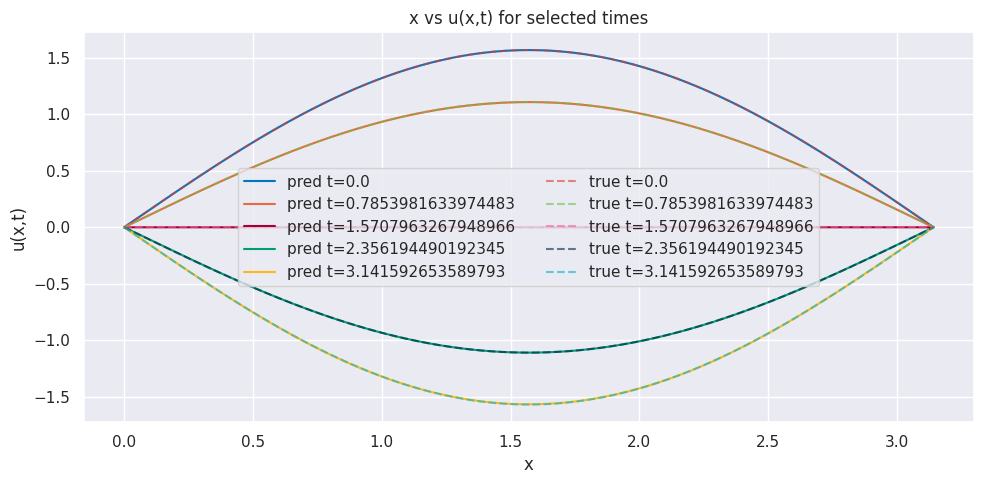

In [12]:
# Plot x vs u(x,t) for multiple time instants using the trained model
import math
import torch
import matplotlib.pyplot as plt

def plot_x_vs_u_at_times(model, times=(0.0, 0.67, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves_u = []
    curves_theta = []
    curves_f = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the first for u
            u_pred_output, _ = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)

            u_pred_output_norm, theta_pred_output_norm, f_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)

            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            theta_pred_output_denorm = theta_normalizer.denormalize(theta_pred_output_norm)
            f_pred_output_denorm = f_normalizer.denormalize(f_pred_output_norm)

            curves_u.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))
            curves_theta.append((t_val, x.squeeze().cpu(), theta_pred_output_denorm.squeeze().cpu()))
            curves_f.append((t_val, x.squeeze().cpu(), f_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves_u:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u_exact' in globals(): # Changed 'u' to 'u_exact' for clarity
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Calculate the new time points: 0, T_end, and 5 evenly spaced times in between
num_times = 5 # 0, t_end, and 5 in between
new_times = np.linspace(0, t_end, num_times)

# Run the plot for default times
plot_x_vs_u_at_times(pinn_inverse, times=new_times, Nx =300, L_val=L, with_exact=True)

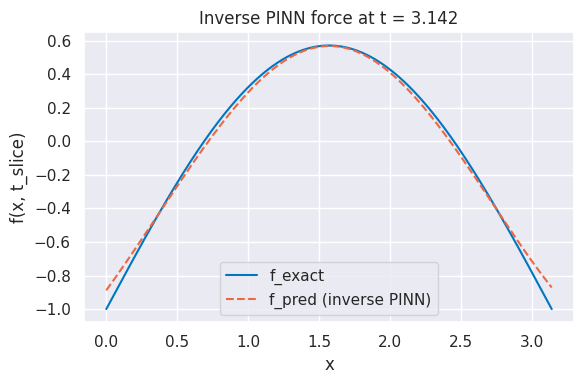

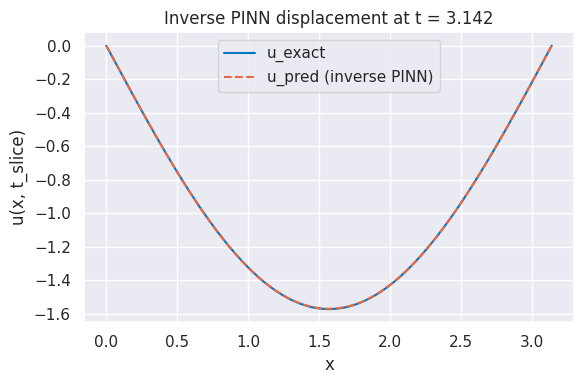

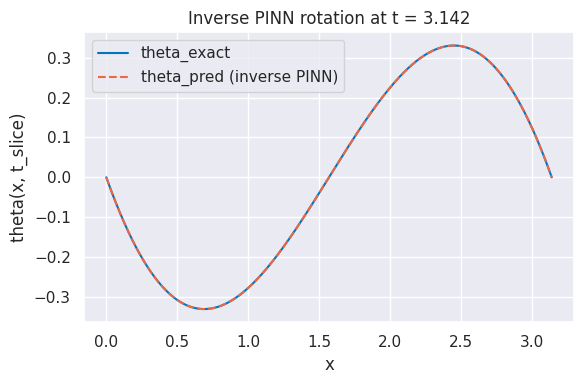

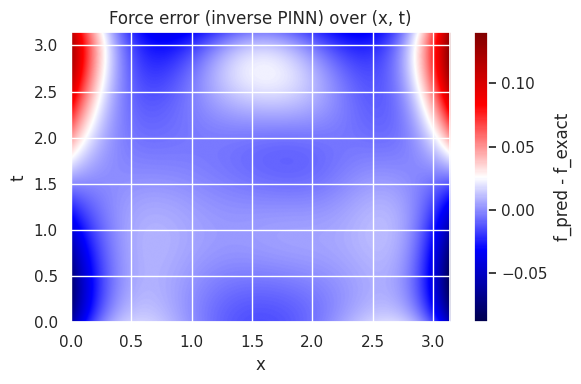

relative error = 0.38788414001464844 %


In [14]:
# Evaluate trained inverse PINN (pinn_inverse): compare f_pred with f_exact
if 'pinn_inverse' not in globals():
    print("pinn_inverse is not defined. Please run the inverse training cell first.")
else:
    pinn_inverse.eval()

    # Create evaluation grid in physical (x, t) coordinates
    n_x = 1000
    n_t = 1000
    x_eval = torch.linspace(0, L, n_x, device=device)
    t_eval = torch.linspace(0, T_end, n_t, device=device)
    X_phys, T_phys = torch.meshgrid(x_eval, t_eval, indexing='ij')  # shapes: [n_x, n_t]

    # Exact solutions on the physical grid
    u_true = u_exact(X_phys, T_phys).cpu()
    theta_true = theta_exact(X_phys, T_phys).cpu()
    f_true = f_exact(X_phys, T_phys).cpu()

    # Model predictions: normalize (x, t) before feeding to the network
    X_norm = x_normalizer.normalize(X_phys)
    T_norm = t_normalizer.normalize(T_phys)

    with torch.no_grad():
        XT_input = torch.stack([X_norm.reshape(-1), T_norm.reshape(-1)], dim=1)  # [n_x*n_t, 2] on device
        u_pred_norm, theta_pred_norm, f_pred_norm = pinn_inverse(XT_input).split(1, dim=-1)

        u_pred = u_normalizer.denormalize(u_pred_norm).reshape(X_phys.shape).cpu()
        theta_pred = theta_normalizer.denormalize(theta_pred_norm).reshape(X_phys.shape).cpu()
        f_pred = f_normalizer.denormalize(f_pred_norm).reshape(X_phys.shape).cpu()

    # Choose a time slice (here: first time index) for visualization
    t_idx = -1
    x_np = x_eval.cpu().numpy()
    f_true_slice = f_true[:, t_idx].numpy()
    f_pred_slice = f_pred[:, t_idx].numpy()

    plt.figure(figsize=(6, 4))
    plt.plot(x_np, f_true_slice, label='f_exact')
    plt.plot(x_np, f_pred_slice, '--', label='f_pred (inverse PINN)')
    plt.xlabel('x')
    plt.ylabel('f(x, t_slice)')
    plt.title(f'Inverse PINN force at t = {t_eval[t_idx].item():.3f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    u_true_slice = u_true[:, t_idx].numpy()
    u_pred_slice = u_pred[:, t_idx].numpy()

    plt.figure(figsize=(6, 4))
    plt.plot(x_np, u_true_slice, label='u_exact')
    plt.plot(x_np, u_pred_slice, '--', label='u_pred (inverse PINN)')
    plt.xlabel('x')
    plt.ylabel('u(x, t_slice)')
    plt.title(f'Inverse PINN displacement at t = {t_eval[t_idx].item():.3f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    theta_true_slice = theta_true[:, t_idx].numpy()
    theta_pred_slice = theta_pred[:, t_idx].numpy()

    plt.figure(figsize=(6, 4))
    plt.plot(x_np, theta_true_slice, label='theta_exact')
    plt.plot(x_np, theta_pred_slice, '--', label='theta_pred (inverse PINN)')
    plt.xlabel('x')
    plt.ylabel('theta(x, t_slice)')
    plt.title(f'Inverse PINN rotation at t = {t_eval[t_idx].item():.3f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2D error heatmap over (x, t)
    error_grid = (f_pred - f_true).numpy()
    plt.figure(figsize=(6, 4))
    plt.imshow(
        error_grid.T,
        extent=[0, float(L), 0, float(T_end)],
        origin='lower',
        aspect='auto',
        cmap='seismic'
    )
    plt.colorbar(label='f_pred - f_exact')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Force error (inverse PINN) over (x, t)')
    plt.tight_layout()
    plt.show()

    # Compute overall mean squared error of the force on the grid
    relative_error = np.mean((f_pred - f_true).numpy()**2) / np.mean(f_true.numpy()**2) * 100
    print(f"relative error = {relative_error} %")